# Simulate proteome time profiles. Perturbation midway by removing carbon source, forcing starvation

In [158]:
import seaborn as sns
import pandas as pd

sns.plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.float_format', lambda x: '%.3g' % x)
%matplotlib inline

In [1]:
PROTOTYPE = False

In [2]:
from dynamicme.tests.helpme import HelpME
from dynamicme.dynamic import get_cplx_concs

helper = HelpME(prototyping=PROTOTYPE)
solver = helper.solver
me = solver.me

In [3]:
cplx_concs_max = get_cplx_concs(solver)

## Make sure delayme works

In [4]:
mu_me = me.solution.x_dict['biomass_dilution']
print 'mu of ME:', mu_me

mu of ME: 0.911689453125


In [5]:
from dynamicme.dynamic import DelayedDynamicME

dyme = DelayedDynamicME(solver)
dyme.delay_model.solver.set_realopts('lp', {'Feasibility tol':1e-15,'Optimality tol':1e-15})
dsolver = dyme.delay_model.solver

In [6]:
%%time
### Make sure it solves
dyme.delay_model.update_cplx_concs(cplx_concs_max)
dyme.delay_model.update_horizon(0.01)
x,stat,hs = dsolver.solvelp(mu_me, basis=dsolver.lp_hs)
dme = dyme.delay_model.mod_me
print 'DelayME:', stat, 'at', dme.reactions.biomass_dilution.x
x_dict_max = dict(dsolver.me.solution.x_dict)

DelayME: optimal at 0.911689453125
CPU times: user 3min 35s, sys: 357 ms, total: 3min 36s
Wall time: 3min 35s


In [7]:
basis_maxmu = dsolver.lp_hs.copy()

# Test 2: Should be able to grow at any slower rate starting from initial proteome for faster growth
- can just scale down formation rates
- as long as rxns allowed to be slower than keff*E, which we did do here

In [ ]:
%%time

dyme.delay_model.update_cplx_concs(cplx_concs_max)
dyme.delay_model.update_horizon(0.01)
x,stat,hs = dsolver.solvelp(mu_me*0.5, basis=basis_maxmu)

In [10]:
print stat
x_dict_opt2 = dict(dsolver.me.solution.x_dict)
cplx_concs_opt2 = get_cplx_concs(dsolver)

optimal


### Difference in cplx concs? Or no change and just under utilizing enzyme capacity?

In [11]:
for k in cplx_concs_max.keys():
    c1 = cplx_concs_max[k]
    c2 = cplx_concs_opt2[k]
    if abs(c1-c2)>1e-15:
        print '%-25.20s%-25.20s%-25.20s' % (c1,c2, k)

0                        3.47047958468e-09        FADA-CPLX                
1.33353118292e-05        1.32584999713e-05        CPLX0-721_mod_mn2        
4.33960463439e-06        4.30039835613e-06        CPLX0-7659               
2.5290368877e-05         2.50618823389e-05        GMP-SYN-CPLX_mod_mg2     
8.05066146918e-07        7.97792754518e-07        CITRATE-SI-SYNTHASE      
4.73810461586e-06        4.69529807848e-06        GARTRANSFORMYL2-MONO     
3.06274114759e-05        3.03507072787e-05        ASL-MONOMER              
2.02099330781e-09        8.27652676439e-09        RpsJ_mono                
1.14598561892e-05        1.13563218011e-05        PPK-CPLX                 
3.20015470976e-05        3.17124282341e-05        RIB5PISOMB-CPLX          
4.90862852726e-07        4.90527768208e-07        PHOSPHAGLYPSYN-MONOM     
1.49095969557e-05        1.4774895789e-05         PRPPSYN-MONOMER_mod_     
8.34975610888e-09        8.27432000607e-09        EG11167-MONOMER          
2.3050805439

In [12]:
cplx_concs_max.values()==cplx_concs_opt2.values()

False

# Test 3: should be able to catalyze faster rates at slower growth starting from fast growth proteome for some rxns but not others

In [13]:
print '%-25.20s%-25.20s%-25.20s%-25s' % ('Flux (opt)', 'Flux (low mu)', 'rxn', 'reaction')
for rid in x_dict_max.keys():
    v1 = x_dict_max[rid]
    v2 = x_dict_opt2[rid]
    #if abs(v2-v1) > 1e-12:
    if abs(v2) - abs(v1) > 1e-12:
        rxn = dme.reactions.get_by_id(rid)
        print '%-25.20s%-25.20s%-25.20s%-25s' % (v1,v2, rid, rxn.reaction)

Flux (opt)               Flux (low mu)            rxn                      reaction                 


# Test 4: given a long enough time horizon, should be able to reach higher-growth proteome starting from slow proteome

In [14]:
%%time
### Need to get a slow-growth proteome separately
mu_slow = mu_me*0.5
x2,stat2,hs2 = solver.solvelp(mu_slow, basis=solver.lp_hs)
print stat2, 'for growth=',mu_slow
cplx_concs_slow = get_cplx_concs(solver)

optimal for growth= 0.455844726562


In [15]:
%%time

### First make sure we can grow at slow proteome
dyme.delay_model.update_cplx_concs(cplx_concs_slow)
dyme.delay_model.update_horizon(0.1)
x,stat,hs = dsolver.solvelp(mu_slow)
print stat
x_dict_slow = dict(dsolver.me.solution.x_dict)

optimal
CPU times: user 4min 13s, sys: 66.7 ms, total: 4min 13s
Wall time: 4min 13s


### Try to grow faster starting from slower proteome
- Should be infeasible for short time horizon

In [16]:
%%time
dyme.delay_model.update_horizon(0.01)
x,stat,hs = dsolver.solvelp( mu_slow + (mu_me-mu_slow)*1 , basis=dsolver.lp_hs)
print stat

1
CPU times: user 1min 24s, sys: 46.7 ms, total: 1min 24s
Wall time: 1min 24s


### Try to grow faster from slow proteome given long time horizon
- should be possible if horizon long enough

In [17]:
%%time
### Might be feasible
dyme.delay_model.update_horizon(1)
x,stat,hs = dsolver.solvelp( mu_slow + (mu_me-mu_slow)*1, basis=dsolver.lp_hs)
print stat

1
CPU times: user 1min 22s, sys: 83.3 ms, total: 1min 22s
Wall time: 1min 22s


### Instead, see what max mu possible starting from slow proteome

In [20]:
%%time
### Might be feasible
dyme.delay_model.update_horizon(0.1)
#x,stat,hs = dsolver.solvelp( mu_slow + (mu_me-mu_slow)*1, basis=dsolver.lp_hs)
muopt, hs, xopt, cache  = dsolver.bisectmu(basis=dsolver.lp_hs)
if dsolver.me.solution is None:
    stat = 1
else:
    stat = dsolver.me.solution.status
print stat

iter	muopt    	a     	b     	mu1       	stat1
Finished substituting S,lb,ub in 3.216468 seconds
Finished makeME_LP in 0.606606 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 1.0 1.0 1
Finished substituting S,lb,ub in 3.132202 seconds
Finished makeME_LP in 0.602961 seconds
Getting MINOS parameters from ME_NLP...
2 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 3.239735 seconds
Finished makeME_LP in 0.605448 seconds
Getting MINOS parameters from ME_NLP...
3 0.5 0.5 0.75 0.75 1
Finished substituting S,lb,ub in 3.148069 seconds
Finished makeME_LP in 0.601101 seconds
Getting MINOS parameters from ME_NLP...
4 0.5 0.5 0.625 0.625 1
Finished substituting S,lb,ub in 3.139181 seconds
Finished makeME_LP in 0.600696 seconds
Getting MINOS parameters from ME_NLP...
5 0.5 0.5 0.5625 0.5625 1
Finished substituting S,lb,ub in 3.095948 seconds
Finished makeME_LP in 0.604583 seconds
Getting MINOS parameters from ME_NLP...
6 0.5 0.5 0.53125 0.53125 1
Finished substituting S,lb,ub in 3

In [23]:
print 'Max from slow proteome=%g, mu for slow proteome=%g' % (muopt, mu_slow)

Max from slow proteome=0.515625, mu for slow proteome=0.455845


## Plot slow & fast-growth proteomes

In [24]:
import pandas as pd

df_prot1 = pd.DataFrame([{'cplx':met.id.replace('delayed_abundance_',''), 'v':met._bound} for met in dsolver.me.metabolites.query('delayed_abundance')])
df_prot1.loc[:,'type'] = 'slow'

In [25]:
df_prot2 = pd.DataFrame([{'cplx':rxn.id.replace('abundance_',''), 'v':rxn.x} for rxn in dsolver.me.reactions.query('abundance_')])
df_prot2.loc[:,'type'] = 'fast'

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:9 RuntimeWarning: invalid value encountered in log2


(array([   2.,  355.,   41.,    5.,    1.,    1.,    0.,    1.,    4.,    1.]),
 array([ -3.44703383,  -1.30484238,   0.83734907,   2.97954053,
          5.12173198,   7.26392343,   9.40611489,  11.54830634,
         13.69049779,  15.83268924,  17.9748807 ]),
 <a list of 10 Patch objects>)

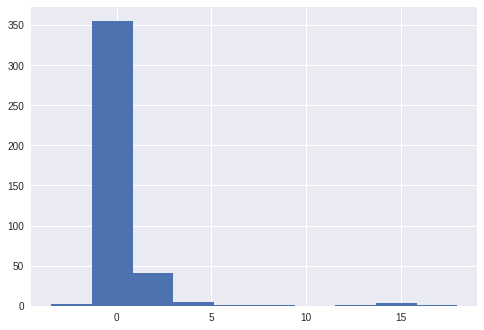

In [26]:
%matplotlib inline
import numpy as np
import seaborn as sns

### Check prots that changed the most
df_val = pd.merge(df_prot1, df_prot2, on='cplx')
df_val.loc[:,'dv'] = df_val.v_y - df_val.v_x
df_val.loc[:,'f_dv'] = df_val.dv / df_val.v_x
df_val.loc[:,'l2fc'] = np.log2(df_val.v_y / df_val.v_x)

sns.plt.hist(df_val.l2fc[ (~df_val.l2fc.isnull()) & (df_val.l2fc < np.inf)])

In [57]:
df_val.head(1)

,cplx,v_x,type_x,v_y,type_y,dv,f_dv,l2fc
0,IscU,0.0,slow,8.238114e-13,fast,8.238114e-13,inf,inf


In [58]:
N_PLOT = 10
cplxs_plot = df_val.sort_values('v_y',ascending=False)['cplx'][0:N_PLOT]

In [59]:
### Convert to mass or mol fractions
tot1 = df_prot1.v.sum()
tot2 = df_prot2.v.sum()
df_prot1.loc[:,'molf'] = df_prot1.v / tot1
df_prot2.loc[:,'molf'] = df_prot2.v / tot2

In [60]:
dsplot = pd.concat([df_prot1, df_prot2])
dsplot2 = dsplot[ dsplot.cplx.isin(cplxs_plot)]
dsplot2.loc[:,'group'] = 'DelayME'

In [61]:
dsplot2.groupby('type').molf.sum()

type
fast    0.736897
slow    0.389324
Name: molf, dtype: float64

In [62]:
dsplot2.head()

,cplx,v,type,molf,group
208,PGK-CPLX,6.771679e-05,slow,0.029804,DelayME
364,G6700-MONOMER,3.417645e-04,slow,0.150417,DelayME
568,FLAVODOXIN2-MONOMER,1.507942e-07,slow,0.000066,DelayME
714,ANTHRANSYNCOMPII-MONOMER,4.585009e-05,slow,0.020180,DelayME
742,N-ACETYLGLUTPREDUCT-MONOMER,1.135518e-04,slow,0.049976,DelayME


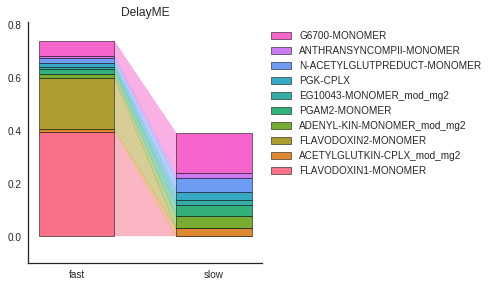

In [67]:
from stressme.plot import stacked_bar
sns.set_style('white')
stacked_bar('type', 'molf', dsplot2, 'cplx', 'group', size=4)

# Test 5: for a shorter time horizon, there may not be a faster proteome in the vicinity of the initial proteome
1. meaning the initial proteome will be kept indefinitely until conditions change, forcing slower growth
1. Also implies that short-term greedy growth maximization strategy won't always work under environmental changes
1. This is why regulation is needed to force short-term growth decrease to build up a better proteome that pays off after an adjustment time (lag, diauxie)

## Preset bioreactor simulation

In [68]:
import warnings

T = 10   # hours
V = 1.   # L
X0 = 0.00675 / V  # g/L
c0_dict = {'glc__D_e': 0.4,
           'lac__L_e': 0.4,
           'malt_e': 0.4,
           'gal_e': 0.4,
           'glyc_e':0.4,
           'ac_e': 0.0}

### Convert from g/L to mmol
mids_remove = []
for mid,c in c0_dict.iteritems():
    try:        
        met = me.metabolites.get_by_id(mid)    
        c0_dict[met.id] = c / met.formula_weight * 1000
    except KeyError:
        warnings.warn('Model has no metabolite: %s. Will remove it from c0_dict' % mid)
        mids_remove.append(mid)

for mid in mids_remove:
    c0_dict.pop(mid)
        
### Set max uptake rate
LB_EX = -10.
LB_O2 = -20.

lb_dict={}
ub_dict={}

for mid in c0_dict.keys():
    try:
        rxn = dyme.get_exchange_rxn(mid)    
        if rxn.id is 'EX_o2_e':
            lb = LB_O2
        else:
            lb = LB_EX
        rxn.lower_bound = lb
        lb_dict[rxn.id] = lb
    except KeyError:
        warnings.warn('Model has no metabolite: '+ mid)

me.reactions.EX_o2_e.lower_bound = -20.
lb_dict[me.reactions.EX_o2_e.id] = -20.
        
print c0_dict
print lb_dict

{'glyc_e': 4.34339676647141, 'malt_e': 1.1685776026677226, 'lac__L_e': 4.4908498933423155, 'gal_e': 2.220299442904667, 'ac_e': 0.0, 'glc__D_e': 2.220299442904667}
{u'EX_glyc_e': -10.0, u'EX_o2_e': -20.0, u'EX_gal_e': -10.0, u'EX_lac__L_e': -10.0, u'EX_malt_e': -10.0, u'EX_ac_e': -10.0, 'EX_glc__D_e': -10.0}


### Seed with suboptimal proteome (slower growth on same substrate)

In [69]:
F_SUBOPT = 0.5

In [70]:
sol_sub = solver.solvelp(mu_me*F_SUBOPT, basis=solver.lp_hs)

In [71]:
cplx_concs = get_cplx_concs(solver)
cplx_conc_dict0 = dict(cplx_concs)

In [72]:
import numpy as np
cvals = np.array(cplx_conc_dict0.values())
cvals[ cvals>0].min()

8.8030963390716137e-15

In [73]:
dyme = DelayedDynamicME(solver)

In [74]:
solver.set_realopts('lp', {'Feasibility tol':1e-15, 'Optimality tol':1e-15})

In [ ]:
dsolver.me.reactions.

In [81]:
if PROTOTYPE:
    fluxes_plot = ['ACONTa_CPLX0-7760_mod_4fe4s', 'ACONTb_CPLX0-7760_mod_4fe4s', 'ACKr_reverse']
else:
    fluxes_plot = [r.id for r in dsolver.me.reactions if isinstance(r,MetabolicReaction)]

In [ ]:
%%time
extra_rxns_tracked = ['EX_o2_e'] + fluxes_plot + ['biomass_dilution']

T = 20
dt = 0.5
H = dt

result = dyme.simulate_batch(
    T,    
    c0_dict,
    X0,
    prec_bs=1e-3,
    ZERO_CONC=0.,
    extra_rxns_tracked=extra_rxns_tracked,
    lb_dict={},
    verbosity=2,
    dt = dt,
    H = H,
    cplx_conc_dict0=cplx_conc_dict0)

Metabolite glyc_e available.
Using default LB=-1000 for EX_glyc_e
Metabolite ac_e depleted.
Metabolite lac__L_e available.
Using default LB=-1000 for EX_lac__L_e
Metabolite malt_e available.
Using default LB=-1000 for EX_malt_e
Metabolite gal_e available.
Using default LB=-1000 for EX_gal_e
Metabolite glc__D_e available.
Using default LB=-1000 for EX_glc__D_e
Computing new uptake rates
Biomass at t=0.5: 0.0088363
Concentrations: {'glyc_e': 4.3403440066465082, 'ac_e': 0.0010231276741350991, 'lac__L_e': 4.4908498933423155, 'malt_e': 1.1685776026677226, 'gal_e': 2.220299442904667, 'glc__D_e': 2.1851412897505815}
Growth rate: 0.6181640625
Metabolite glyc_e available.
Using default LB=-1000 for EX_glyc_e
Metabolite ac_e available.
Using default LB=-1000 for EX_ac_e
Metabolite lac__L_e available.
Using default LB=-1000 for EX_lac__L_e
Metabolite malt_e available.
Using default LB=-1000 for EX_malt_e
Metabolite gal_e available.
Using default LB=-1000 for EX_gal_e
Metabolite glc__D_e available

### Save results

In [147]:
import json
result2 = result.copy()
result2.keys()
result2.pop('basis')

with open('/home/laurence/ME/data/dynamicME/testing/iLE_sim.json','w') as f:
    json.dump(result2, f)

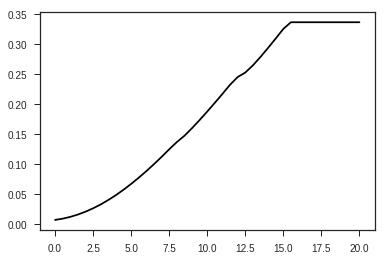

In [95]:
import seaborn as sns
%matplotlib inline

sns.plt.plot(result['time'], result['biomass'])

In [96]:
ex_met_rxn_dict = {m: {'rxn':dyme.get_exchange_rxn(m), 'mw':me.metabolites.get_by_id(m).formula_weight} for m in c0_dict.keys()}
ex_met_rxn_dict

{'ac_e': {'mw': 59.04402, 'rxn': <Reaction EX_ac_e at 0x7f2b90ca6950>},
 'gal_e': {'mw': 180.15588, 'rxn': <Reaction EX_gal_e at 0x7f2b91ebfd50>},
 'glc__D_e': {'mw': 180.15588,
  'rxn': <Reaction EX_glc__D_e at 0x7f2b84d9ab90>},
 'glyc_e': {'mw': 92.09382, 'rxn': <Reaction EX_glyc_e at 0x7f2b90b1cf50>},
 'lac__L_e': {'mw': 89.07, 'rxn': <Reaction EX_lac__L_e at 0x7f2b7fe9ffd0>},
 'malt_e': {'mw': 342.29648, 'rxn': <Reaction EX_malt_e at 0x7f2b92b69810>}}

In [97]:
import pandas as pd

df_conc = pd.DataFrame(result['concentration'])
### Convert concentrations to g/L
for mid, vals in ex_met_rxn_dict.iteritems():
    df_conc[mid] = df_conc[mid] * vals['mw'] * 0.001

df_time = pd.DataFrame({'time':t, 'biomass':b} for t,b in zip(result['time'], result['biomass']))
df_flux = pd.DataFrame(result['ex_flux'])
df_mu   = pd.DataFrame({'mu':result['growth_rate']})
df_result = pd.concat([df_time, df_conc, df_flux, df_mu], axis=1)

In [98]:
dsplot = pd.melt(df_result, id_vars='time', value_vars=['biomass','ac_e','gal_e','glc__D_e','glyc_e','lac__L_e','malt_e'])
dsplot.time = pd.to_numeric(dsplot.time)
dsplot['category'] = 'Metabolite'
dsplot.loc[ dsplot.variable=='biomass', 'category'] = 'Biomass'

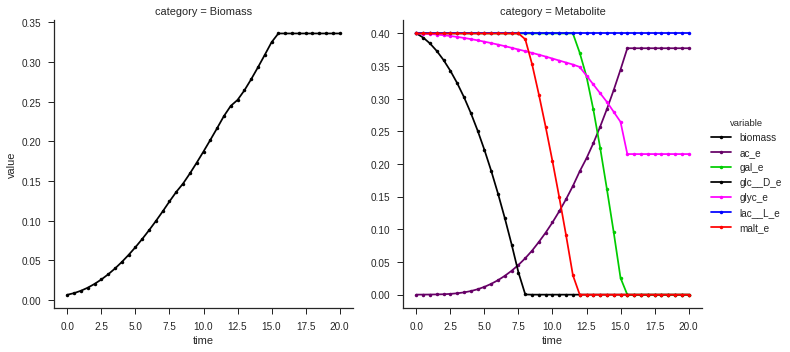

In [99]:
colors = [
'#000000', # biomass
'#660066', # acetate
'#00CC00', #'#00FF00', # galactose
'#000000', # glucose
'#FF00FF', # glycerol
'#0000FF', # lactate
'#FF0000', # maltose
]

colpal = sns.color_palette(colors)
sns.set_palette(colpal)

g = sns.FacetGrid(data=dsplot, hue='variable', col='category', sharey=False, size=5)

g.map(sns.plt.plot, 'time', 'value', linestyle='-', marker='.')
g.add_legend()

In [100]:
if PROTOTYPE:
    complexes_plot = ['IPPMIa_E_c', 'ACKr_reverse_E_c', 'CPLX0-7760_mod_4fe4s','CPLX0-7761_mod_4fe4s']
else:
    complexes_plot = ['3-ISOPROPYLMALISOM-CPLX_mod_4fe4s', 'ACETATEKINA-MONOMER_mod_mg2', 'CPLX0-7659']

In [117]:
fluxes_plot2 = []

for rid in fluxes_plot:
    rxn = dsolver.me.reactions.get_by_id(rid)
    if abs(rxn.x) > 10:
        fluxes_plot2.append(rxn.id)
        
print len(fluxes_plot2)

9


In [118]:
df_mu = pd.DataFrame([{'time':t, 'variable':'growth_rate', 'value':c, 'category':'growth'} for t,c in zip(result['time'], result['growth_rate'])] )

df_complex = pd.DataFrame([{'time':t, 'complex':c, 'abundance':cdict[c]} 
                           for t,cdict in zip(result['time'], result['complex']) for c in complexes_plot] )

df_mflux = pd.DataFrame([{'time':t, 'rxn':c, 'flux':cdict[c]} 
                           for t,cdict in zip(result['time'], result['rxn_flux']) for c in fluxes_plot2] )

df_complex.loc[:,'category'] = 'complex'
df_mflux.loc[:,'category'] = 'flux'

dsplot_all = pd.concat([dsplot,
                        df_mu,
                          df_complex.rename(columns={'complex':'variable', 'abundance':'value'}),
                          df_mflux.rename(columns={'rxn':'variable', 'flux':'value'})])

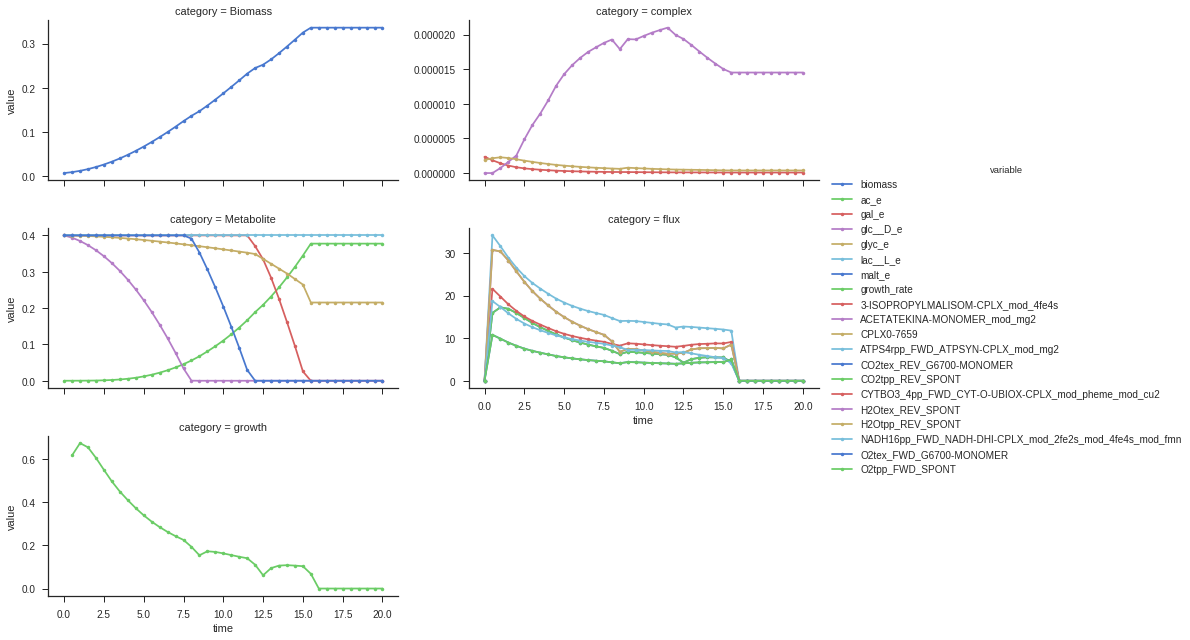

In [121]:
sns.set_style('ticks')
palette = sns.color_palette('muted', len(dsplot_all.variable.unique()))
g = sns.FacetGrid(data=dsplot_all, hue='variable', sharey=False, size=3, col='category', palette=palette,
                  aspect=2, col_wrap=2, col_order=['Biomass','complex','Metabolite','flux','growth'])
g.map(sns.plt.plot, 'time', 'value', linestyle='-', marker='.')
g.add_legend()

In [148]:
result.keys()

['rxn_flux',
 'complex',
 'ex_flux',
 'time',
 'concentration',
 'basis',
 'biomass',
 'growth_rate']

## Proteome mol (mass) fractions

In [122]:
df_cplx = pd.DataFrame([{'cplx':k, 'conc':v, 'time':result['time'][i]} for i,r in enumerate(result['complex']) for k,v in r.iteritems()])

times = df_cplx.time.unique()
for t in times:
    dfi = df_cplx[ df_cplx.time==t]
    mtot = dfi.conc.sum()
    b = (df_cplx.time==t).values
    df_cplx.loc[b,'molf'] = df_cplx.loc[b,'conc'] / mtot
    
df_var = df_cplx.groupby('cplx').molf.var().reset_index()
df_var.molf.min()
df_var.molf.max()
N_PLOT = 10
vary_cplxs = df_var.sort_values('molf', ascending=False)['cplx'][0:N_PLOT].values
vary_cplxs

array(['FLAVODOXIN2-MONOMER', 'G6700-MONOMER',
       'N-ACETYLGLUTPREDUCT-MONOMER', 'ADENYL-KIN-MONOMER_mod_mg2',
       'PGAM2-MONOMER', 'ACETYLGLUTKIN-CPLX_mod_mg2', 'PGK-CPLX',
       'EG10043-MONOMER_mod_mg2', 'ANTHRANSYNCOMPII-MONOMER',
       'AROA-MONOMER'], dtype=object)

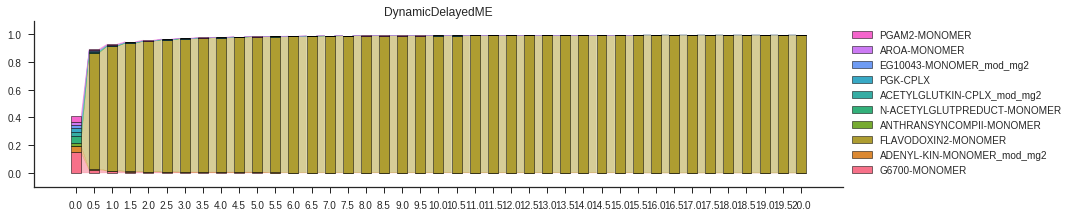

In [123]:
dsplot_cplx = df_cplx[ df_cplx.cplx.isin(vary_cplxs)]
dsplot_cplx.loc[:,'group'] = 'DynamicDelayedME'
stacked_bar('time', 'molf', dsplot_cplx, 'cplx', 'group', aspect=4)

## Expression fluxes

## Check |slacks|>ftol for equality constraints to find infeasible

- Ax + s = 0
- Ax = -s

import numpy as np
infeas_cons = {}

ZERO = 1e-15
N = len(dsolver.me.reactions)
M = len(dsolver.me.metabolites)
           
for met in dsolver.me.metabolites:
    if met._constraint_sense == 'E':
        i = dsolver.me.metabolites.index(met)        
        s = x[N+i]
        b = met._bound
        e = b+s # since -s = b OR b+s = 0
        if abs(e) > ZERO:
            infeas_cons[met.id] = e
max_abs_infeas = max(abs(np.array(infeas_cons.values())))
print 'Max abs primal infeas:', max_infeas
print 'Min abs primal infeas:', min(abs(np.array(infeas_cons.values())))
print 'Sum of abs infeas:', sum(abs(np.array(infeas_cons.values())))
print '# of infeasibilities:', len(infeas_cons)